# About Dataset

link https://www.kaggle.com/datasets/wardabilal/real-estate-price-insights/data



Introduction

This dataset provide information the property of different houses and their selling prices.Through this dataset, we can understand how factors like bedrooms, bathrooms, area, and furnishing affect the price of a house.This dataset is beneficial for those student who learn prediction of price through data analysis or machine learning.

Context


One of the most frequent problems in the real estate sector is figuring out what influences property values. This dataset is used to construct prediction models that forecast property prices based on particular qualities and provides important insights into the housing market.

## Imports

In [16]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout


## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("wardabilal/real-estate-price-insights")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/wardabilal/real-estate-price-insights/versions/1


In [3]:
print(os.listdir(path))

['Housing_Price_Data.csv']


In [4]:
df = pd.read_csv(os.path.join(path,'Housing_Price_Data.csv'))
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Explore The Data

In [5]:
df.isna().sum().sum()

np.int64(0)

In [6]:
df.duplicated().sum()

np.int64(0)

## Preprocessing

In [7]:
# Select boolean columns
boolean_cols = df.select_dtypes(include='object').columns

# Convert 'yes' and 'no' to 1 and 0 for boolean columns
for col in boolean_cols:
    df[col] = df[col].replace({'yes': 1, 'no': 0})

/tmp/ipython-input-1579979837.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'yes': 1, 'no': 0})


In [8]:
cat = ['furnishingstatus']

dummy = pd.get_dummies(df[cat]).astype(int)

df = pd.concat([df, dummy], axis=1)
df = df.drop(cat, axis=1)

In [9]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


## See How Data Looks

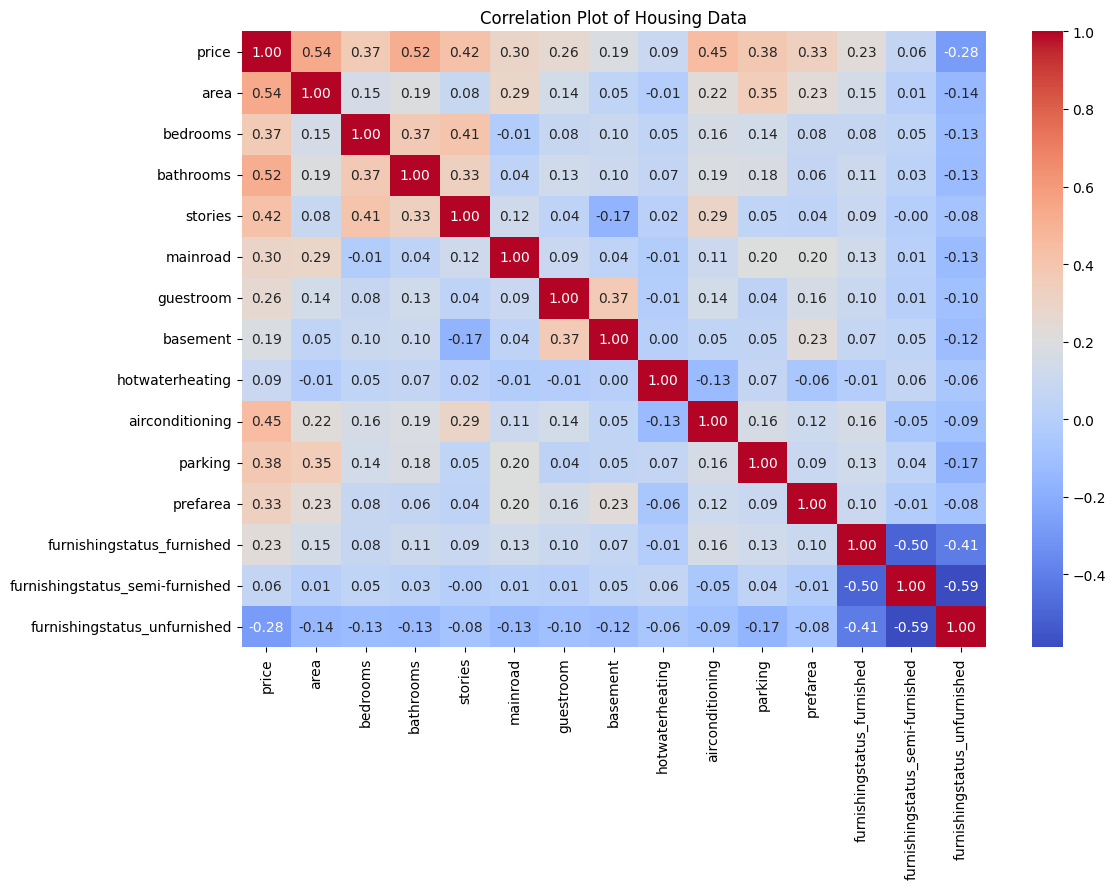

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot of Housing Data')
plt.show()

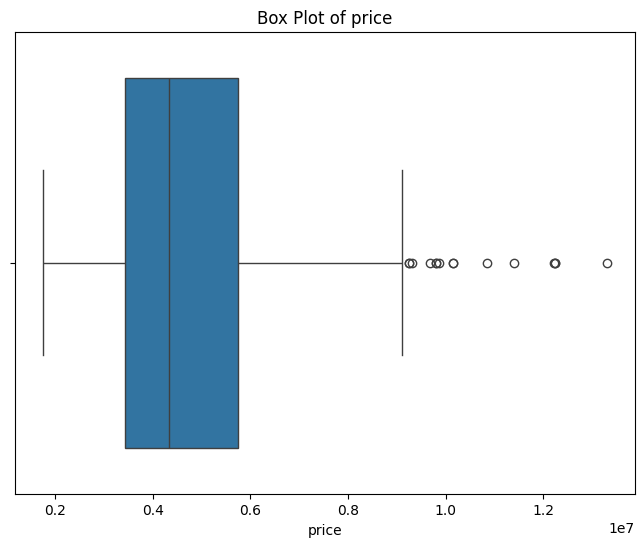

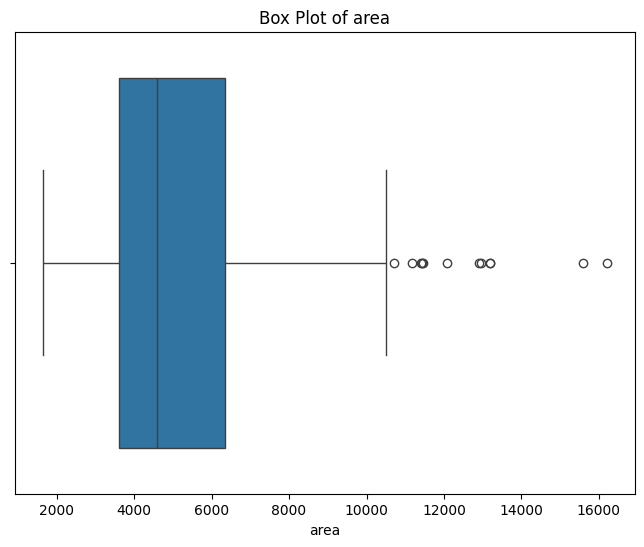

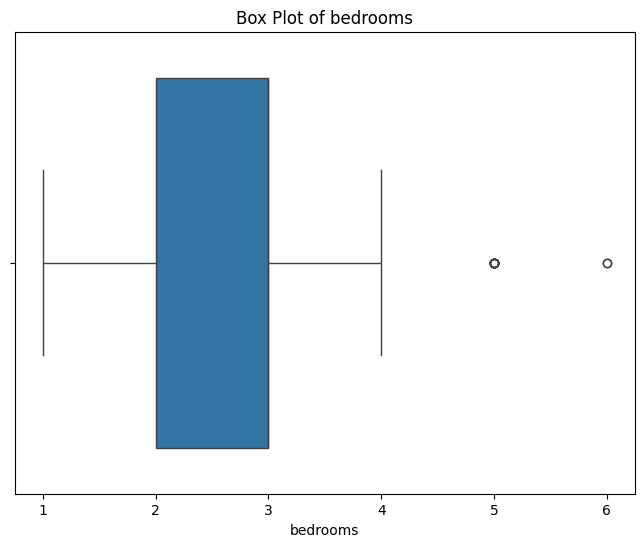

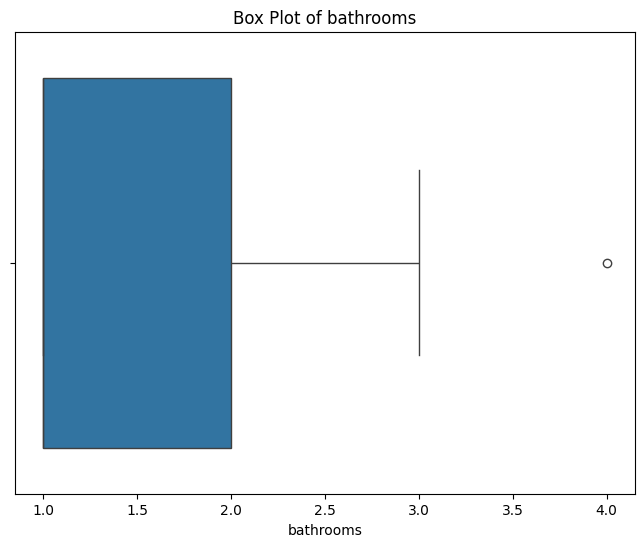

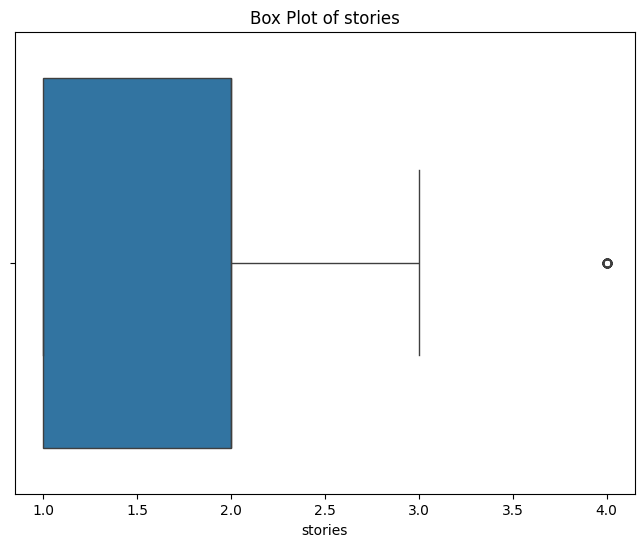

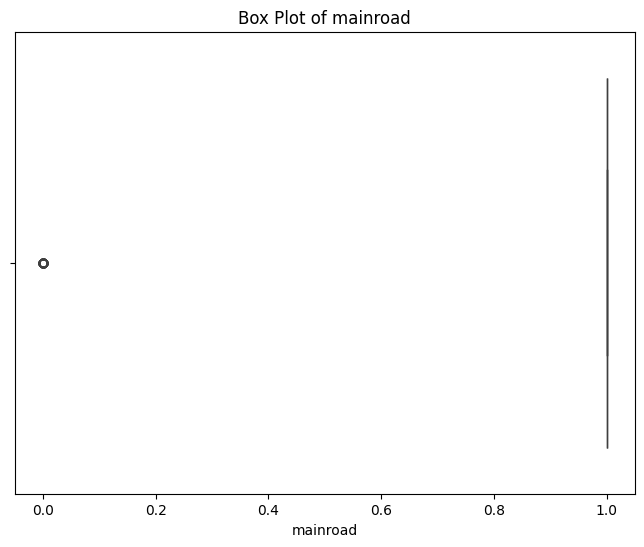

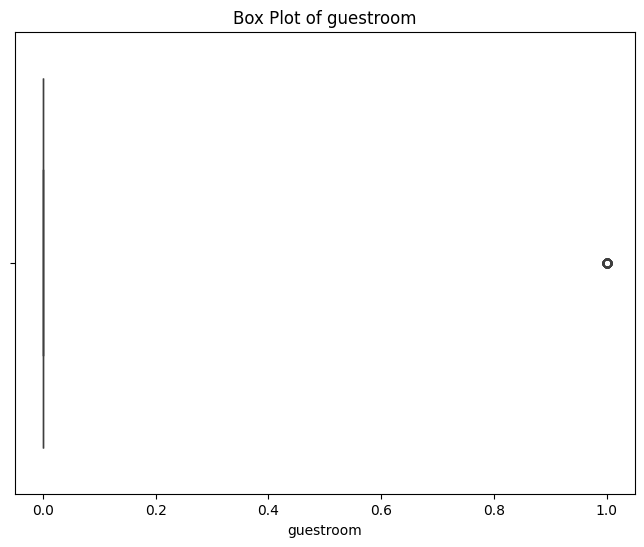

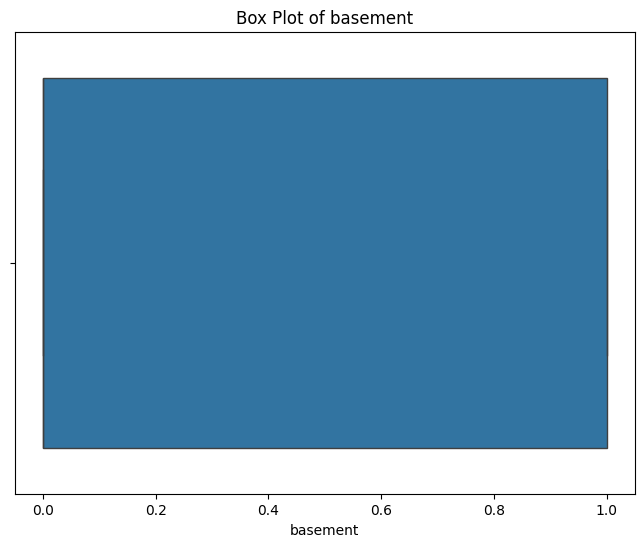

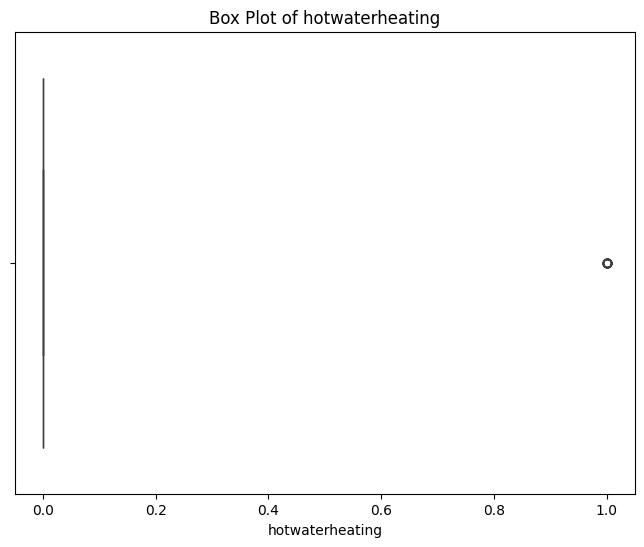

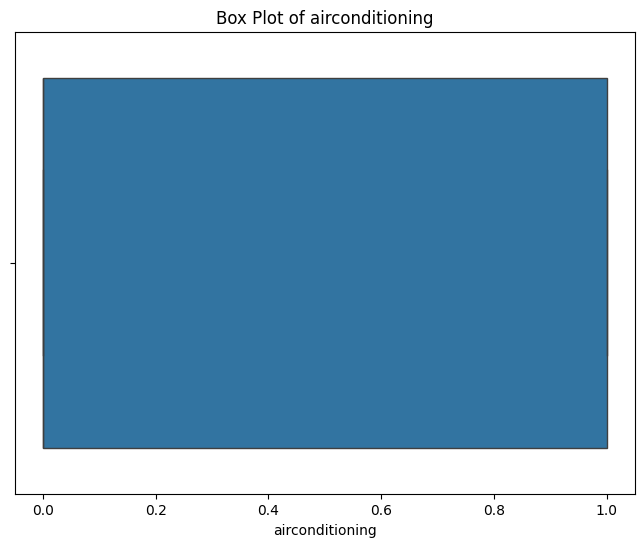

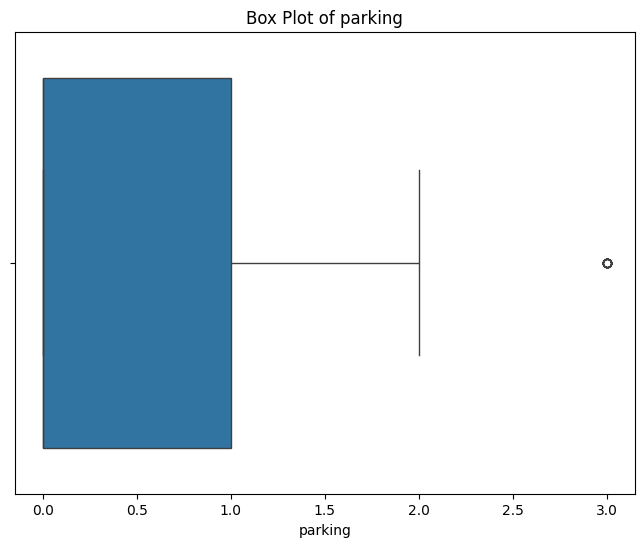

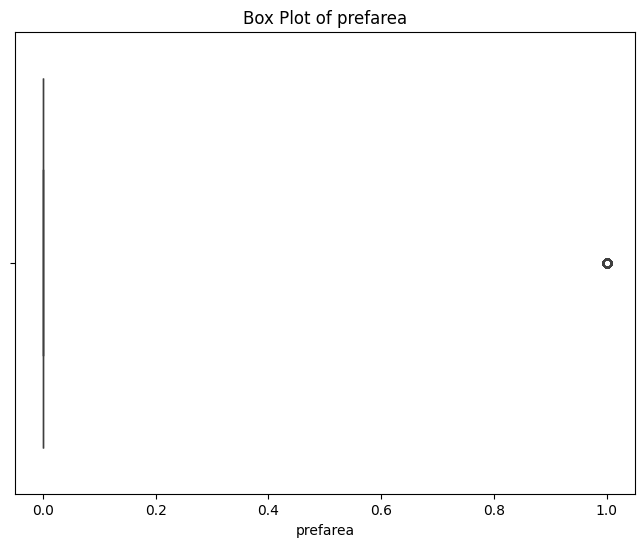

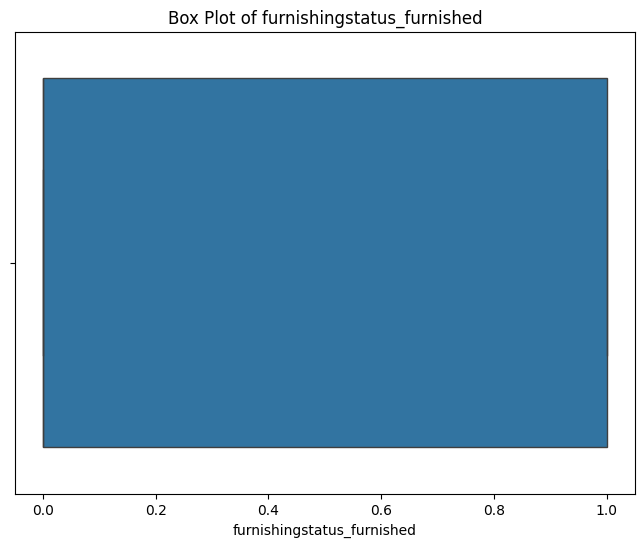

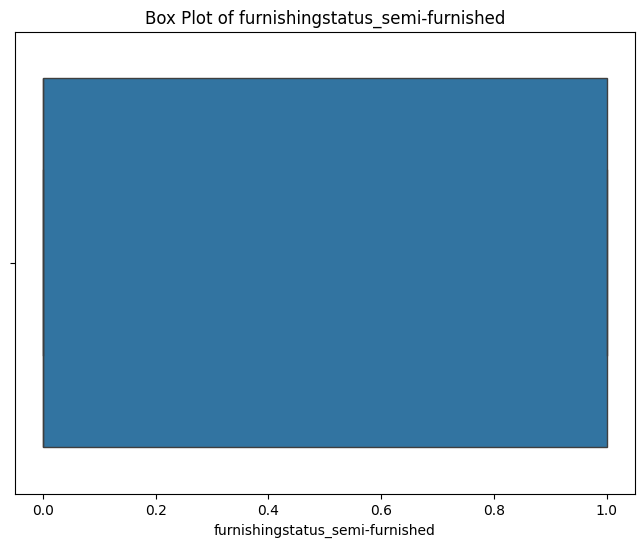

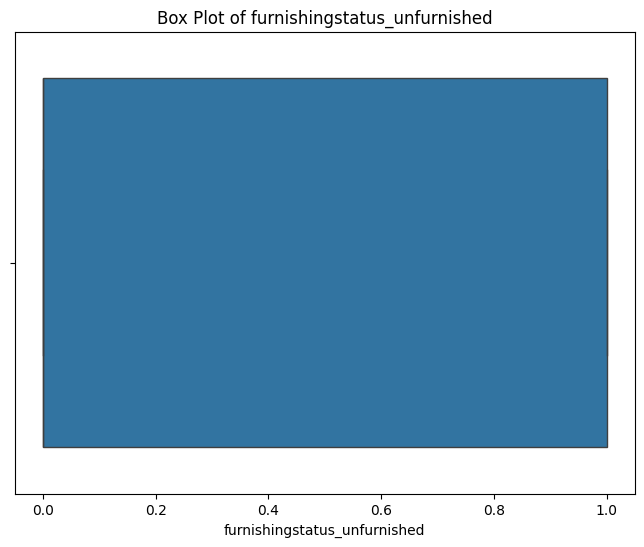

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

# Create box plots for numerical columns to visualize outliers
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

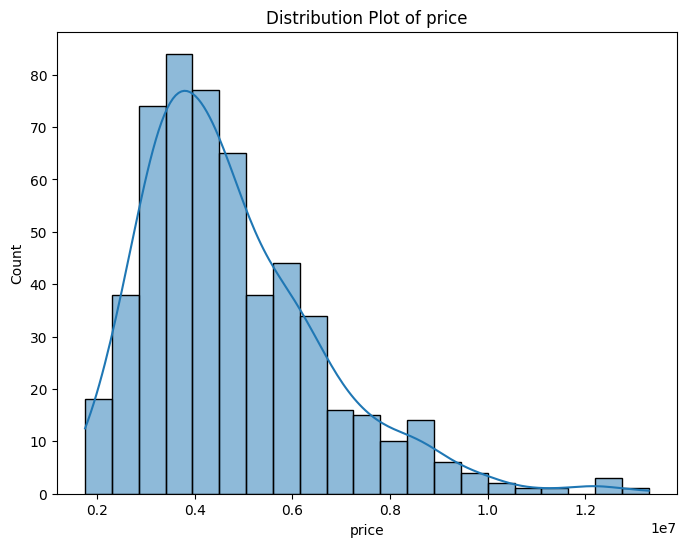

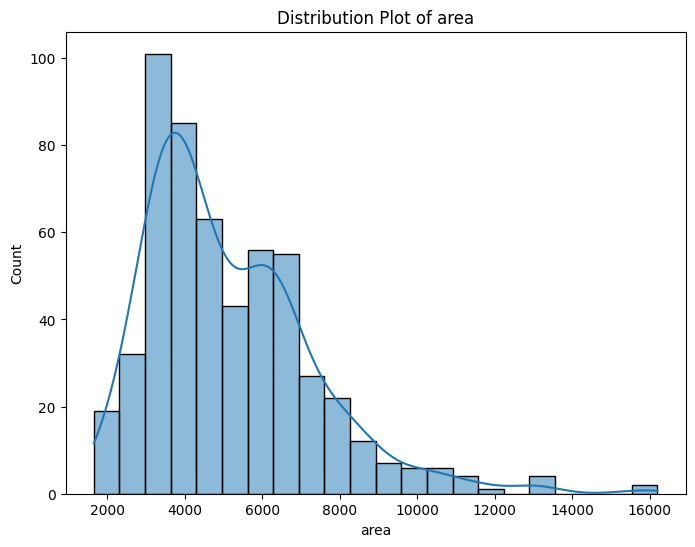

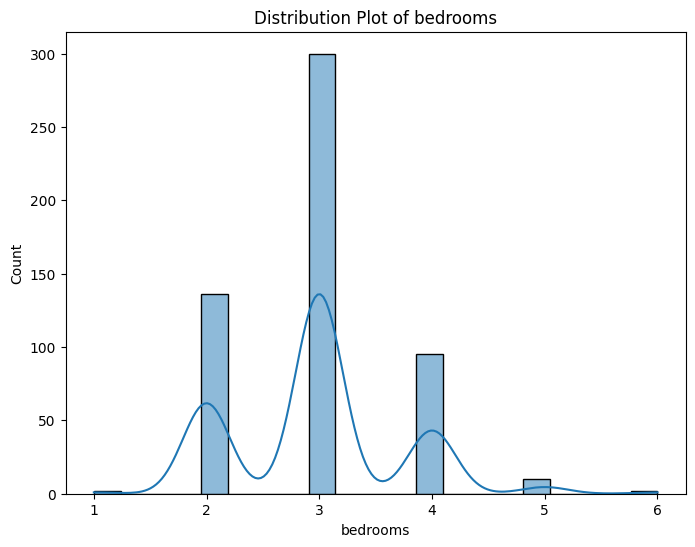

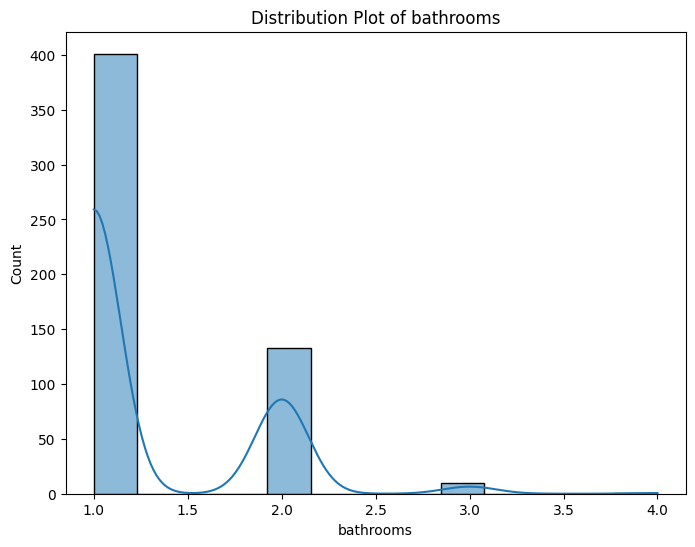

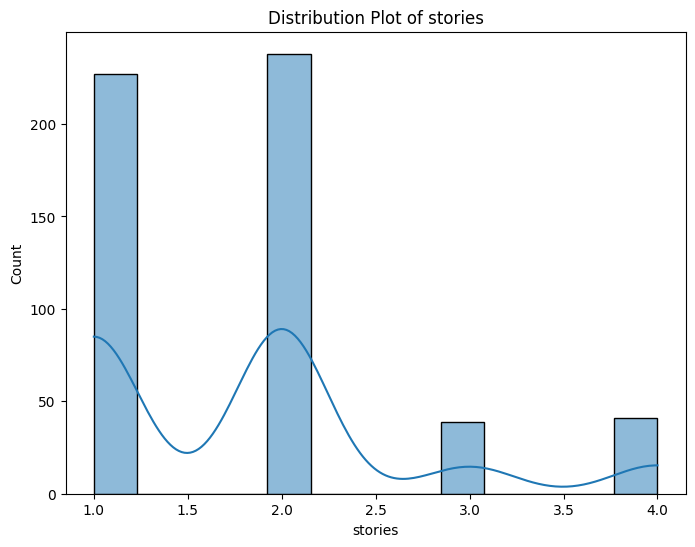

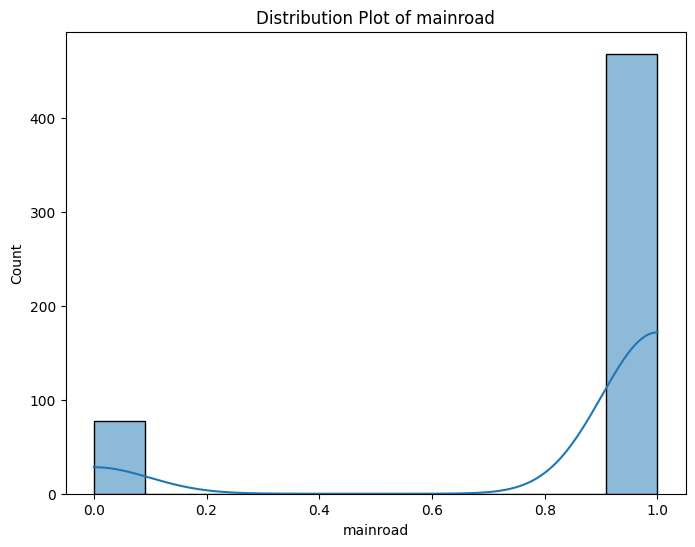

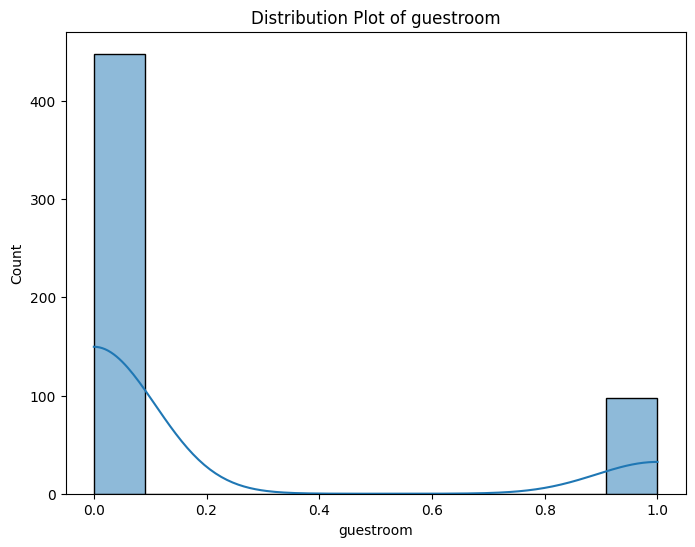

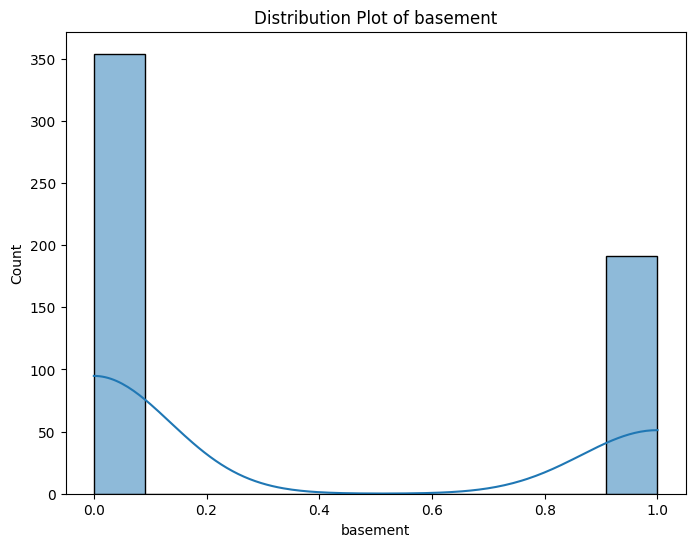

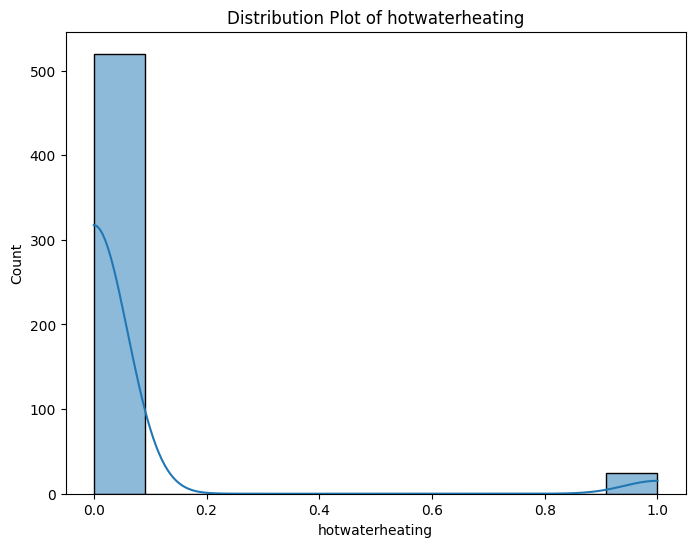

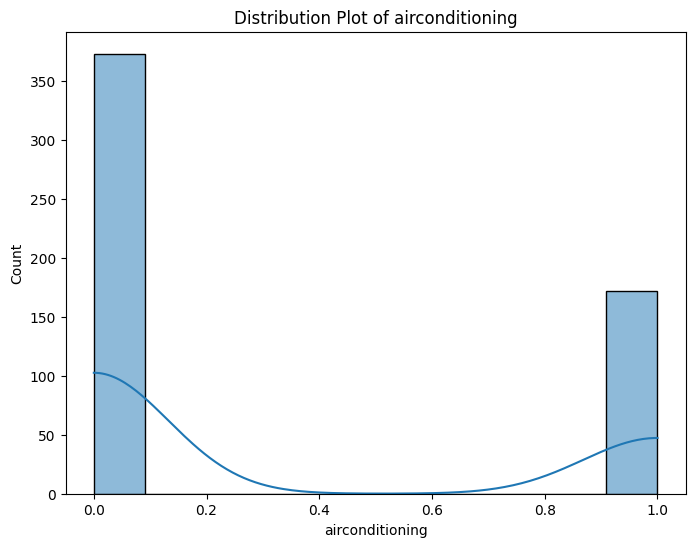

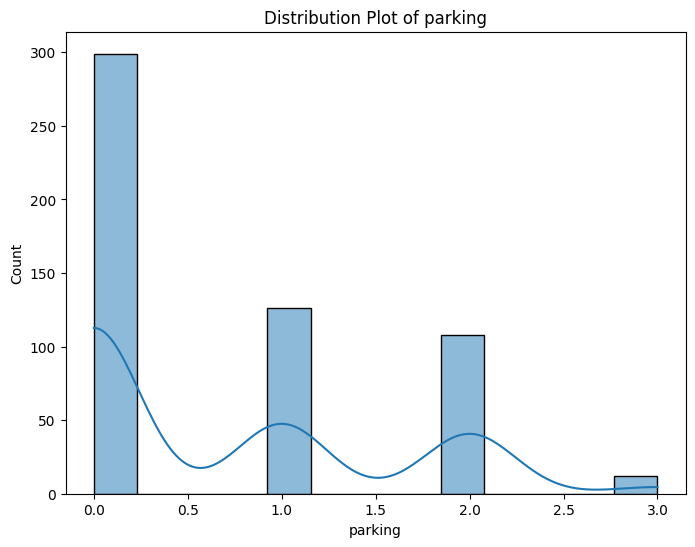

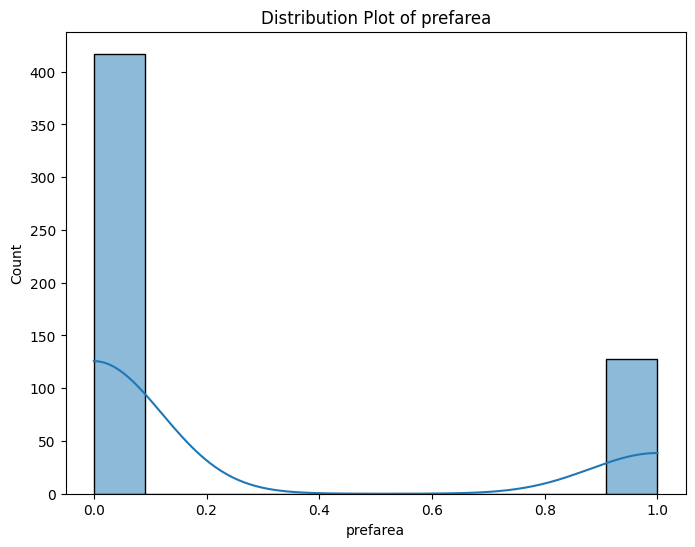

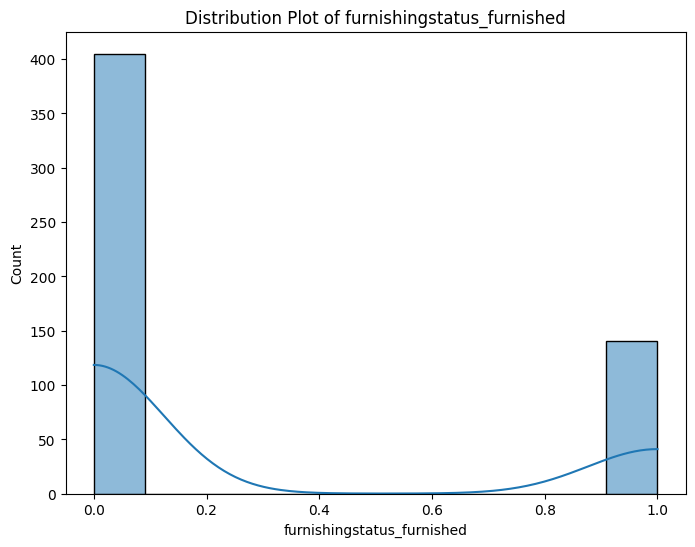

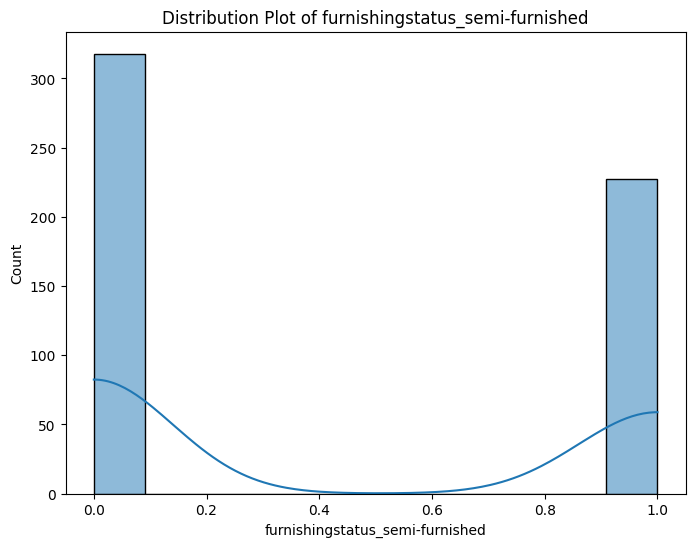

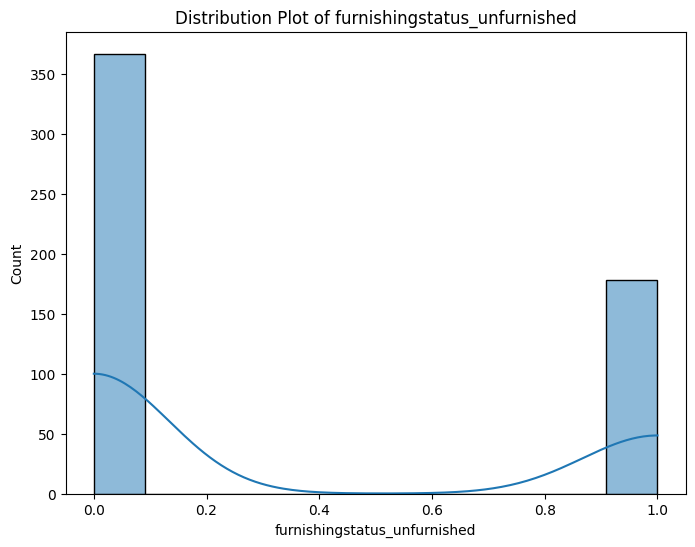

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

# Create distribution plots for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution Plot of {col}')
    plt.show()

## Outliers Detection

In [13]:
num_cols = df.drop('price', axis=1).columns


Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check how many outliers each column has
outlier_counts = ((df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)).sum()
print(outlier_counts)


area                                12
bedrooms                            12
bathrooms                            1
stories                             41
mainroad                            77
guestroom                           97
basement                             0
hotwaterheating                     25
airconditioning                      0
parking                             12
prefarea                           128
furnishingstatus_furnished           0
furnishingstatus_semi-furnished      0
furnishingstatus_unfurnished         0
dtype: int64


In [14]:
num_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']


Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for col in num_cols:
    df[col] = np.where(df[col] < lower_bound[col], lower_bound[col],
                       np.where(df[col] > upper_bound[col], upper_bound[col], df[col]))


((df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)).sum()


,0
area,0
bedrooms,0
bathrooms,0
stories,0
parking,0


still have mild outliers vso we need to ue Robust Scaler

## Train Test Split

In [15]:
# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize RobustScaler
scaler = RobustScaler()

# Fit on training data and transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Quick check
print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (436, 14)
Test shape: (109, 14)


In [17]:
#  Sklearn models + MLPRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ),
    "MLPRegressor": MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=2000,
        random_state=42
    )
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    results.append({
        "Model": name,
        "R² Score": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })


## Neural Networks

In [18]:
tf.random.set_seed(42)

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')   # regression output
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

# Predict with NN
y_pred_nn = nn_model.predict(X_test_scaled).reshape(-1)

results.append({
    "Model": "Keras_NN",
    "R² Score": r2_score(y_test, y_pred_nn),
    "MAE": mean_absolute_error(y_test, y_pred_nn),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_nn))
})



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


##  Show leaderboard

In [19]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R² Score", ascending=False)
results_df

,Model,R² Score,MAE,RMSE
4,GradientBoosting,0.662128,9.395384e+05,1.306827e+06
5,MLPRegressor,0.654626,9.803605e+05,1.321256e+06
0,LinearRegression,0.652853,9.803468e+05,1.324642e+06
2,Lasso,0.652853,9.803468e+05,1.324642e+06
1,Ridge,0.652376,9.806601e+05,1.325552e+06
6,Keras_NN,0.641552,1.007024e+06,1.346032e+06
3,RandomForest,0.615148,1.009201e+06,1.394726e+06



## Conclusion



In [20]:
print("Final Model Comparison Summary")
display(results_df)

print("""
The dataset was cleaned and preprocessed by:
• Converting categorical variables to numeric (0/1)
• Handling outliers using IQR capping
• Applying RobustScaler to mitigate the effect of remaining outliers
• Splitting data into training and testing sets

Model Performance Summary:
• Gradient Boosting achieved the highest R² score (~0.66) with the lowest RMSE and MAE.
• Neural models (MLPRegressor and Keras Neural Network) performed competitively,
  confirming that the target variable has some non-linear relationships with predictors.
• Linear, Ridge, and Lasso regressions produced similar results (~0.65 R²),
  showing that a linear component is also present in the data.
• Random Forest performed slightly worse, likely due to parameter defaults or limited data size.

Conclusion:
Gradient Boosting currently provides the best performance among tested models.
However, further improvements can be made by:
• Performing hyperparameter tuning for Gradient Boosting, XGBoost, and LightGBM
• Experimenting with deeper or regularized neural networks
• Using cross-validation to obtain more robust performance estimates
""")


Final Model Comparison Summary


,Model,R² Score,MAE,RMSE
4,GradientBoosting,0.662128,9.395384e+05,1.306827e+06
5,MLPRegressor,0.654626,9.803605e+05,1.321256e+06
0,LinearRegression,0.652853,9.803468e+05,1.324642e+06
2,Lasso,0.652853,9.803468e+05,1.324642e+06
1,Ridge,0.652376,9.806601e+05,1.325552e+06
6,Keras_NN,0.641552,1.007024e+06,1.346032e+06
3,RandomForest,0.615148,1.009201e+06,1.394726e+06



The dataset was cleaned and preprocessed by:
• Converting categorical variables to numeric (0/1)
• Handling outliers using IQR capping
• Applying RobustScaler to mitigate the effect of remaining outliers
• Splitting data into training and testing sets

Model Performance Summary:
• Gradient Boosting achieved the highest R² score (~0.66) with the lowest RMSE and MAE.
• Neural models (MLPRegressor and Keras Neural Network) performed competitively,
  confirming that the target variable has some non-linear relationships with predictors.
• Linear, Ridge, and Lasso regressions produced similar results (~0.65 R²),
  showing that a linear component is also present in the data.
• Random Forest performed slightly worse, likely due to parameter defaults or limited data size.

Conclusion:
Gradient Boosting currently provides the best performance among tested models.
However, further improvements can be made by:
• Performing hyperparameter tuning for Gradient Boosting, XGBoost, and LightGBM
• Exper